# Preprocessing Data

In [1]:
import retentioneering
import pandas as pd

C:\Users\sharonova\AppData\Roaming\Python\Python37\site-packages\umap\__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


Firstly, we need to initialize our config file

Посчитаем:
    
- как вели себя люди перед 

In [2]:
retentioneering.config.update({
    'experiments_folder': 'experiments', # folder for saving experiment results: graph visualization, heatmaps and etc.
    'user_col': 'session_id', # column by which we split users / sessions / whatever
    'event_col': 'event', # column that describes event
    'event_time_col': 'event_dt', # column that describes timestamp of event
    'positive_target_event': 'returned', # name of positive target event
    'negative_target_event': 'lost', # name of negative target event
    'pos_target_definition': { # how to define positive event, e.g. empty means that add passed for whom was not 'lost'
        'event_list': ['returned']
    },
#     'neg_target_definition': { # how to define negative event, e.g. users who were inactive for 600 seconds.  
#     },
    'neg_target_definition':{ # you also can define target event as list of other events
        'event_list': ['lost']
    }
})

We need to create instance of pandas DataFrame with our data.

In [4]:
from clickhouse_driver import Client as CH
import pandas as pd
import time
import json
import pyexasol
from IPython.display import HTML, Javascript

import numpy as np

#config
CONFIGFILE =  ('C:/Users/sharonova/Documents/Python Scripts/config_file.ini')

#connection
from configparser import ConfigParser
cfg = ConfigParser()
cfg.read(CONFIGFILE)

global _ch, sql, _sqlcache
_sqlcache = {}
_ch = CH('thanos.clickhouse.analytics.tutu.ru', user=cfg['clickhouse_thanos']['user'],
         password=cfg['clickhouse_thanos']['password']).execute
def sql(sqlText, cache=True):
    ret = _sqlcache.get(sqlText, None)
    if ret is not None and cache: return ret
    ts = time.time()
    resp = _ch(sqlText, with_column_types=True)
    if len(resp)==2:
        ret = pd.DataFrame(resp[0], columns=[c[0] for c in resp[1]])
    else: ret = resp
    if cache: _sqlcache[sqlText] = ret
    return ret

url_ch = cfg['clickhouse_thanos']
from clickhouse_driver import Client as CH
ch = CH(url_ch['host'], user=url_ch['user'], password=url_ch['password'])
url_exa = cfg['exasol']
EXA = pyexasol.connect(dsn=url_exa['dsn'], user=url_exa['user'], password=url_exa['password'], compression=True)

def datetime_to_utc (strtime, format='%Y-%m-%d %H:%M:%S'):
    return int(time.mktime(time.strptime(strtime, format)))

In [5]:
dates_goal = ['2021-01-14', '2021-01-21']
dates_event = ['2021-01-13', '2021-11-21']
dates_other_goals = ['2021-01-13', '2021-01-26']

In [9]:
exa_first_order = EXA.export_to_pandas("""
             SELECT email 'email',
             concat((case when product='Авиа' then 'forder'
                          when product='ЖД' then 'zhd_order'
                          when product='Автобусы' then 'bus_order'
                         else product end), '_',order_id) 'order_id',
                         os_name 'os_name'
                         from
             (SELECT  email
                         ,order_id
                         ,order_date
                         ,product
                         ,(case when platform = 'Android ПТТ' then 'android' else 'ios' end) os_name
                         ,RANK() OVER (PARTITION BY email ORDER BY order_date ASC) N
                         -- ,MIN(o.order_date) AS 'first_order_date'
                FROM     common.ORDERS o
                where platform_app_name='ПТТ'
                and product not in ('Туры', 'Приключения')
                and order_date<='{dt1} 23:59:59'
                and email is not null) m
                where N=1
                and order_date between '{dt0} 00:00:00' and '{dt1} 23:59:59'
            """.format(dt0=dates_goal[0], dt1=dates_goal[1]))

resp = ch.execute("""
            select toString(_session) session_id, 
                        _id order_id,
                        type goal_type, 
                        time goal_dt
            from default.uw_goal
            where _id in {}
                    """.format(tuple(exa_first_order.order_id)), with_column_types=True)
ch_first_order = pd.DataFrame(resp[0], columns=[c[0] for c in resp[1]])
ch_first_order = ch_first_order.merge(exa_first_order, on='order_id')
ch_first_order['session_id'] = np.where(ch_first_order.os_name=='ios', 
                                                ch_first_order.session_id.str.upper(), 
                                                ch_first_order.session_id)
ch_first_order = ch_first_order.sort_values(['session_id', 'goal_dt']).groupby('session_id')\
        .first().reset_index('session_id')

In [11]:
exa_first_order.groupby('os_name').email.nunique(),\
ch_first_order.groupby('os_name').email.nunique()

(os_name
 android    5649
 ios        2815
 Name: email, dtype: int64, os_name
 android    5050
 ios        2464
 Name: email, dtype: int64)

In [13]:
ch_first_order.groupby('os_name').email.nunique()['android']/\
exa_first_order.groupby('os_name').email.nunique()['android'],\
ch_first_order.groupby('os_name').email.nunique()['ios']/\
exa_first_order.groupby('os_name').email.nunique()['ios'],\

(0.8939635333687378, 0.8753108348134991)

In [14]:
m_android = list(set(exa_first_order[exa_first_order.os_name=='android'].order_id)\
         -set(ch_first_order[ch_first_order.os_name=='android'].order_id))
m_ios = list(set(exa_first_order[exa_first_order.os_name=='ios'].order_id)\
         -set(ch_first_order[ch_first_order.os_name=='ios'].order_id))

In [15]:
m_android_zhd = [x.split('_')[-1] for x in m_android if '_'.join(x.split('_')[:-1])=='zhd_order']
m_ios_zhd = [x.split('_')[-1] for x in m_ios if '_'.join(x.split('_')[:-1])=='zhd_order']

m_android_bus = [x.split('_')[-1] for x in m_android if '_'.join(x.split('_')[:-1])=='bus_order']
m_ios_bus = [x.split('_')[-1] for x in m_ios if '_'.join(x.split('_')[:-1])=='bus_order']


android - 3.29.3, 
ios - 3.37.0, 

In [24]:
0.13*0.17*100

2.21

In [20]:
print('android')
print('----')
round(100*pd.Series(['_'.join(x.split('_')[:-1]) for x in m_android]).value_counts(normalize=True))

android
----


bus_order    86.0
zhd_order    11.0
forder        3.0
dtype: float64

In [21]:
print('ios')
print('----')
round(100*pd.Series(['_'.join(x.split('_')[:-1]) for x in m_ios]).value_counts(normalize=True))

ios
----


bus_order    81.0
zhd_order    17.0
forder        2.0
dtype: float64

In [329]:
resp = ch.execute("""
            select toString(_session) session_id, 
                        _id order_id,
                        type goal_type, 
                        time goal_dt
            from default.uw_goal
            where object = '35289808'
                    """.format(tuple(m[0])), with_column_types=True)
v = pd.DataFrame(resp[0], columns=[c[0] for c in resp[1]])

In [332]:
resp = ch.execute("""
            select toDate(time) dt, 
                        count(distinct _id) ses
            from default.uw_goal
            where time between '2020-10-01 00:00:00' and '2020-12-31 00:00:00'
            group by dt
                    """, with_column_types=True)
v = pd.DataFrame(resp[0], columns=[c[0] for c in resp[1]])

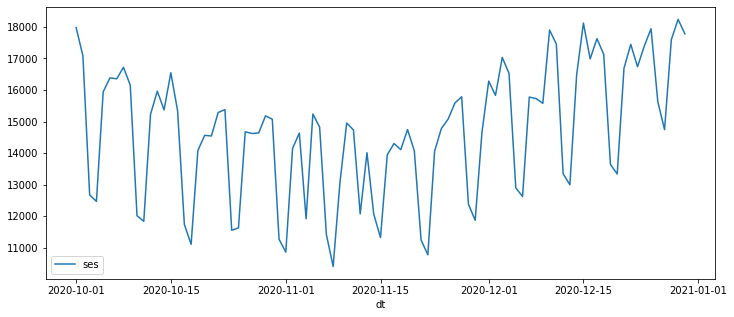

In [335]:
v.set_index('dt').plot(figsize=(12, 5))

In [325]:
v

,session_id,order_id,goal_type,goal_dt
0,5b52095f-0377-453f-8d66-67ebeeb78524,zhd_order_35289189,zhd_order,2020-11-02 19:17:04
1,6d51037a-6ab6-40ae-bb9f-859a24b0dbe5,zhd_order_35297500,zhd_order,2020-11-03 12:51:05
2,034cf9fc-eb2a-4fc1-a595-93e4dee1a405,zhd_order_35278693,zhd_order,2020-11-02 02:19:04
3,c14f7d4e-5f8e-4cfc-b777-48a3aeb78d78,forder_33140378,forder,2020-11-06 09:21:07
4,0467b944-f06b-4967-9cb6-b60fdcbeaa92,zhd_order_35338099,zhd_order,2020-11-06 08:58:32
5,1c7912f9-93b0-4c5d-af3d-66faed9b7daa,forder_33096685,forder,2020-11-03 02:27:04
6,01c77c01-b402-4323-ac3d-0e66dcdfdc2f,forder_33088367,forder,2020-11-02 15:39:15
7,1640eac2-8ca6-40a6-ad71-9802b4fc4fc8,forder_33149588,forder,2020-11-06 19:33:37


In [313]:
ch_first_order = ch_first_order.merge(exa_first_order, on='order_id')
ch_first_order['session_id'] = np.where(ch_first_order.os_name=='ios', 
                                                ch_first_order.session_id.str.upper(), 
                                                ch_first_order.session_id)
ch_first_order = ch_first_order.sort_values(['session_id', 'goal_dt']).groupby('session_id')\
        .first().reset_index('session_id')

In [315]:
d = ch_first_order[ch_first_order.os_name=='ios']

In [390]:
resp = ch.execute("""
            select os_name,
count(distinct if(os_name='ios', ios_ifa, google_aid)) session_id
                from appmetrica.events
                where event_name='Wizard.PassengersEditing.Error'
                and application_id in (1031406, 1031364)
                and event_datetime>='2020-11-01 00:00:00'
                group by os_name
                    """, with_column_types=True)
pd.DataFrame(resp[0], columns=[c[0] for c in resp[1]])

,os_name,session_id
0,android,55787


In [34]:
def sql_for_date(dates_goal, dates_event, dates_other_goals):
    
    exa_first_order = EXA.export_to_pandas("""
             SELECT email 'email',
             concat((case when product='Авиа' then 'forder'
                          when product='ЖД' then 'zhd_order'
                          when product='Автобусы' then 'bus_order'
                         else product end), '_',order_id) 'order_id',
                         os_name 'os_name'
                         from
             (SELECT  email
                         ,order_id
                         ,order_date
                         ,product
                         ,(case when platform = 'Android ПТТ' then 'android' else 'ios' end) os_name
                         ,RANK() OVER (PARTITION BY email ORDER BY order_date ASC) N
                         -- ,MIN(o.order_date) AS 'first_order_date'
                FROM     common.ORDERS o
                where platform_app_name='ПТТ'
                and product not in ('Туры', 'Приключения')
                and order_date<='{dt1} 23:59:59'
                and email is not null) m
                where N=1
                and order_date between '{dt0} 00:00:00' and '{dt1} 23:59:59'
            """.format(dt0=dates_goal[0], dt1=dates_goal[1]))

    resp = ch.execute("""
            select toString(_session) session_id, 
                        _id order_id,
                        type goal_type, 
                        time goal_dt
            from default.uw_goal
            where _id in {}
                    """.format(tuple(exa_first_order.order_id)), with_column_types=True)
    ch_first_order = pd.DataFrame(resp[0], columns=[c[0] for c in resp[1]])

    ch_first_order = ch_first_order.merge(exa_first_order, on='order_id')
    ch_first_order['session_id'] = np.where(ch_first_order.os_name=='ios', 
                                                ch_first_order.session_id.str.upper(), 
                                                ch_first_order.session_id)
    ch_first_order = ch_first_order.sort_values(['session_id', 'goal_dt']).groupby('session_id')\
        .first().reset_index('session_id')

    exa_other_orders = EXA.export_to_pandas("""
             SELECT email 'email',
             concat((case when product='Авиа' then 'forder'
                          when product='ЖД' then 'zhd_order'
                          when product='Автобусы' then 'bus_order'
                         else product end), '_',order_id) 'order_id' ,
                         order_date 'goal_dt'
                FROM     common.ORDERS o
                where platform_app_name='ПТТ'
                and product not in ('Туры', 'Приключения')
                and order_date between '{dt0} 00:00:00' and '{dt1} 23:59:59'
                and email is not null
            """.format(dt0=dates_other_goals[0], dt1=dates_other_goals[1]))

    exa_other_orders = ch_first_order.merge(exa_other_orders, on='email', suffixes=('_1', ''))
    exa_other_orders = exa_other_orders[exa_other_orders.order_id_1!=exa_other_orders.order_id]\
            .sort_values(['session_id', 'goal_dt']).groupby('session_id').first().reset_index('session_id')\
                [['session_id','goal_dt', 'os_name']]

    ch_first_order = ch_first_order[['session_id', 'goal_dt', 'os_name']]

    ses_cnt = round(len(list(ch_first_order.session_id))/2)
    resp = ch.execute("""
            select if(os_name='ios', ios_ifa, google_aid) session_id,
                    event_datetime event_dt,
                    event_name event,
                    os_name
                from appmetrica.events
                where event_datetime between '{begin} 00:00:00' and '{end} 23:59:59'
                and application_id in (1031406, 1031364)
                and session_id in {ses}
                and event_name not like 'Success%'
                and event_name not like '%_loaded'
                and event_name not like 'Route%'
                and event_name not like 'DeepLink%'
                and event_name not like 'WIZARD_%'
                and event_name not like 'hope_%'
                and event_name not like 'ORDERS_%'
                and event_name not like 'PASSENGERS_%'
                and event_name not like 'PRICE_CHANGE_%'
                and event_name not like 'BookOrder%'
                and event_name not like 'Suggester%'
                and event_name not like 'NotificationsRequest%'
                and event_name not like '%Loaded%'
                and event_name not like '%Confirm%'
                    """.format(begin=dates_event[0], end=dates_event[1], ses=tuple(list(ch_first_order.session_id))[:ses_cnt]
                              ), with_column_types=True)
    event_df1 = pd.DataFrame(resp[0], columns=[c[0] for c in resp[1]])

    resp = ch.execute("""
            select if(os_name='ios', ios_ifa, google_aid) session_id,
                    event_datetime event_dt,
                    event_name event,
                    os_name
                from appmetrica.events
                where event_datetime between '{begin} 00:00:00' and '{end} 23:59:59'
                and application_id in (1031406, 1031364)
                and session_id in {ses}
                and event_name not like 'Success%'
                and event_name not like '%_loaded'
                and event_name not like 'Route%'
                and event_name not like 'DeepLink%'
                and event_name not like 'WIZARD_%'
                and event_name not like 'hope_%'
                and event_name not like 'ORDERS_%'
                and event_name not like 'PASSENGERS_%'
                and event_name not like 'PRICE_CHANGE_%'
                and event_name not like 'BookOrder%'
                and event_name not like 'Suggester%'
                and event_name not like '%Loaded%'
                and event_name not like '%Confirm%'
                    """.format(begin=dates_event[0], end=dates_event[1], ses=tuple(list(ch_first_order.session_id))[ses_cnt:]
                              ), with_column_types=True)
    event_df2 = pd.DataFrame(resp[0], columns=[c[0] for c in resp[1]])

    event_df = event_df1.append(event_df2, ignore_index=True)
    event_df = event_df.merge(ch_first_order, on=['session_id', 'os_name'], suffixes=('_event','_goal'))
    event_df = event_df[event_df.goal_dt>=event_df.event_dt]
    event_df = event_df[['session_id','event', 'event_dt', 'os_name']]

    ch_first_order['event'] = np.where(~ch_first_order.session_id.isin(list(exa_other_orders.session_id)),
                                        'lost', 'returned')
    event_final_df = ch_first_order[ch_first_order.session_id.isin(list(set(event_df.session_id)))].rename({'goal_dt':'event_dt'}, axis=1)\
                .append(event_df).sort_values(['session_id', 'event_dt'])
    event_final_df['event_dt'] = event_final_df.event_dt.astype('datetime64[ns]').apply(lambda x:datetime_to_utc(str(x)))
    return event_final_df

In [26]:
"dates_goal = ['2020-11-01', '2020-11-07']
dates_event = ['2020-10-31', '2020-11-07']
dates_other_goals = ['2020-11-01', '2021-01-26']

In [27]:
#data = pd.concat([sql_for_date(x) for x in ['2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-14', '2020-11-15']])

In [28]:
data = sql_for_date(dates_goal, dates_event, dates_other_goals)

In [29]:
data.head()

,session_id,event_dt,os_name,event
88230,002666c4-7d62-4ac6-be25-27229f9b2346,1604115239,android,PushWoosh.Initialize
88234,002666c4-7d62-4ac6-be25-27229f9b2346,1604115239,android,PushWoosh.InitializeAfterMetricaInit
88235,002666c4-7d62-4ac6-be25-27229f9b2346,1604136705,android,Main.Show
88236,002666c4-7d62-4ac6-be25-27229f9b2346,1604136705,android,Application.InstalledApps
88239,002666c4-7d62-4ac6-be25-27229f9b2346,1604136705,android,Application.Launch


In [30]:
data_android = data[data.os_name=='android'].drop(['os_name'], axis=1)
data_ios = data[data.os_name=='ios'].drop(['os_name'], axis=1)

In [31]:
data.groupby('os_name').session_id.nunique()

os_name
android    3789
ios         735
Name: session_id, dtype: int64

In [32]:
def delete_events(df, seconds=86400):
    tbl = df.merge(df[df.event.isin(['lost', 'returned'])], 
                   on='session_id', suffixes=('', '_2'))
    tbl = tbl[((tbl.event_dt_2-tbl.event_dt)<=86400)][['session_id', 'event', 'event_dt']]
    return tbl

In [33]:
data_android = delete_events(data_android)
data_ios = delete_events(data_ios)

# Clustering

If we use method `get_clusters` retentioneering library does the following:  
  
  
1) For each trajectory we calculate its vector in some space. E.g. if we use default value of `feature_type` parameter vectors are calculated using tf-idf metrics:  
TF<sub>event</sub> is the normalized frequency of the event or n-gram in the trajectory (we can add n-grams too in the parameter `nragms_range`, default value is (1, 1) or simply using only single events for vectorizing). If a user has 10 events 3 of which are `onboarding_welcome_screen` then TF<sub>onboarding_welcome_screen</sub> = 0.3  
IDF<sub>event</sub> is the inversed document frequency of our event or n-gram. IDF<sub>event</sub> equals natural logarithm of number of trajectories (users) divided by count of trajectories including the event  
TF-IDF<sub>event</sub> = TF<sub>event</sub> * IDF<sub>event</sub>  
See `exctract_features` method in [utils.py](https://github.com/retentioneering/retentioneering-tools/blob/master/retentioneering/core/utils.py) and `tfidf-embedder` method in [feature_extraction.py](https://github.com/retentioneering/retentioneering-tools/blob/master/retentioneering/core/feature_extraction.py) for more details  
  
2) After we calculated vector form of each trajectory we can use the clustering algorithm.  
Default one is `KMeans`. See `simple_cluster` method in [clustering.py](https://github.com/retentioneering/retentioneering-tools/blob/master/retentioneering/core/clustering.py)  
  
3) When clusters are calculated their heatmap is visualized using `seaborn` library

Clutermap allows to see how important different events are for clustering.
For example we can see that `onboarding_welcome_screen` is always equal, so it does not affect clustering, but `onboarding_chooseLoginType` varies accross users and creates some clusters.

Then it will be useful to visualize projection of user trajectories to understand how many clusters we have.

To find the TSNE-projection of trajectories vectors we use method `learn_tsne`  
If TF-IDF based vectors or clusters calculation haven't been done the method calculates them before using `TSNE` and visualizing clusters in the projection.  
See `learn_tsne` method in [feature_extraction.py](https://github.com/retentioneering/retentioneering-tools/blob/master/retentioneering/core/feature_extraction.py)

We can see that projection is poor, so it will be good to tune it. To update TSNE weights we need to set `refit` parameter to `True`.

Any parameter from `sklearn.manifold.TSNE` can be used, e.g. `perplexity` can help to obtain better visualization.

Now we can see two dense cirle clusters.

Any parameters from `sklearn.cluster.KMeans` can be used.

In [273]:
data_android.rete.get_clusters(method='kmeans',
                       n_clusters=8,
                       refit_cluster=True,
                       feature_type='tfidf',
                       ngram_range=(1,2));

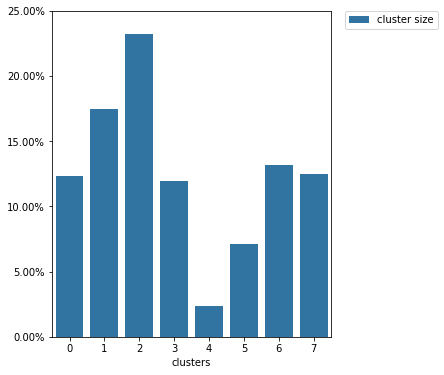

In [274]:
data_android.rete.get_clusters(method='kmeans',
                       feature_type='tfidf',
                       n_clusters=8,
                       ngram_range=(1,2),
                       plot_type='cluster_bar');

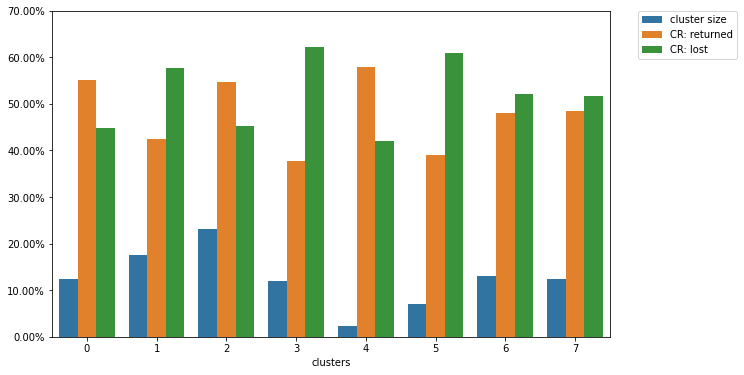

In [275]:
data_android.rete.get_clusters(method='kmeans',
                       feature_type='tfidf',
                       n_clusters=8,
                       ngram_range=(1,2),
                       plot_type='cluster_bar',
                       targets=['returned', 'lost']);

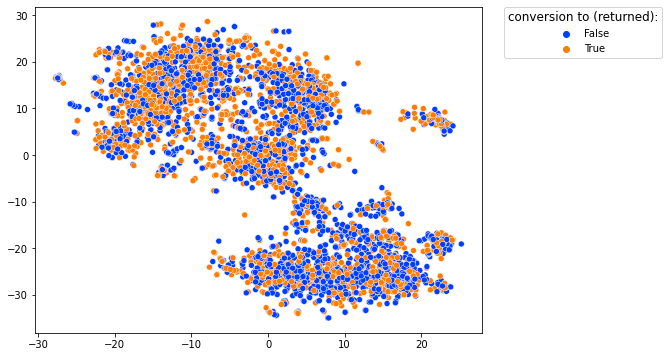

In [276]:
data_android.rete.project(plot_type ='targets',
                  targets = ['returned'],
                  method='tsne',
                  perplexity = 128);

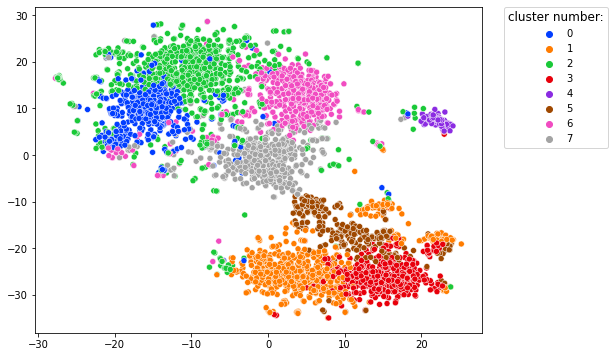

In [277]:
data_android.rete.project(plot_type ='clusters',
                  method='tsne',
                  perplexity=128);

We do not use target events in clustering, so we can compare different groups in terms of what target event is likely to occur in them.

In [278]:
#Искали жд через вкладку жд и переходили несколько раз от страницы выбора вагона к странице выбора мест и сохраненным пассажирам
data_android.rete.filter_cluster(0).rete.plot_graph(thresh=0.25,
                       weight_col='session_id',
                       targets = {'lost':'red',
                                  'returned':'green'})

'experiments/graph_2021-01-27 20_58_47_244091.html'

In [284]:
#Искали через вкладку авиа и пользовались сортировкой по цене
data_android.rete.filter_cluster(1).rete.plot_graph(thresh=0.35,
                       weight_col='session_id',
                       targets = {'lost':'red',
                                  'returned':'green'})

'experiments/graph_2021-01-27 21_11_14_532464.html'

In [295]:
#Искали жд через вкладку жд
data_android.rete.filter_cluster(2).rete.plot_graph(thresh=0.25,
                       weight_col='session_id',
                       targets = {'lost':'red',
                                  'returned':'green'})

'experiments/graph_2021-01-27 21_59_12_467049.html'

In [281]:
#Искали через вкладку авиа и сталкивались с ошибкой passengersediting.error
data_android.rete.filter_cluster(3).rete.plot_graph(thresh=0.35,
                       weight_col='session_id',
                       targets = {'lost':'red',
                                  'returned':'green'})

'experiments/graph_2021-01-27 20_58_49_694737.html'

In [288]:
#Искали через общую выдачу, переключали вкладки на авиа, жд и меняли данные профиля
data_android.rete.filter_cluster(4).rete.plot_graph(thresh=0.20,
                       weight_col='session_id',
                       targets = {'lost':'red',
                                  'returned':'green'})

'experiments/graph_2021-01-27 21_29_17_835531.html'

In [290]:
#Переходили с главной на общую выдачу и там кликали чаще на карточку авиа, чем на переключение вкладок, потом возвращались. 
# Сталкивались с ошибкой passengereditingerror
data_android.rete.filter_cluster(5).rete.plot_graph(thresh=0.20,
                       weight_col='session_id',
                       targets = {'lost':'red',
                                  'returned':'green'})

'experiments/graph_2021-01-27 21_38_39_661138.html'

In [291]:
#Закрывали онбординг, а потом искали через общую вкладку и переходили на жд
data_android.rete.filter_cluster(6).rete.plot_graph(thresh=0.20,
                       weight_col='session_id',
                       targets = {'lost':'red',
                                  'returned':'green'})

'experiments/graph_2021-01-27 21_45_24_269119.html'

In [294]:
#Искали через общую выдачу, переключались на жд
data_android.rete.filter_cluster(7).rete.plot_graph(thresh=0.20,
                       weight_col='session_id',
                       targets = {'lost':'red',
                                  'returned':'green'})

'experiments/graph_2021-01-27 21_51_11_574332.html'

### iOS

In [336]:
data_ios.rete.get_clusters(method='kmeans',
                       n_clusters=5,
                       refit_cluster=True,
                       feature_type='tfidf',
                       ngram_range=(1,2));

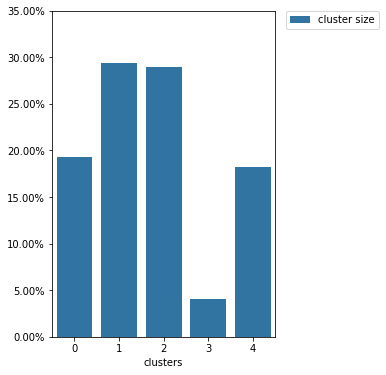

In [337]:
data_ios.rete.get_clusters(method='kmeans',
                       feature_type='tfidf',
                       n_clusters=5,
                       ngram_range=(1,2),
                       plot_type='cluster_bar');

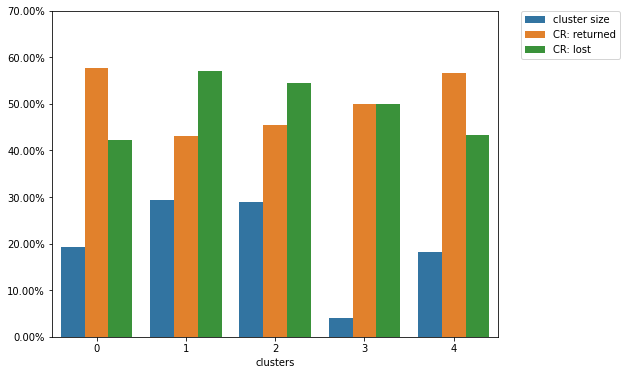

In [338]:
data_ios.rete.get_clusters(method='kmeans',
                       feature_type='tfidf',
                       n_clusters=5,
                       ngram_range=(1,2),
                       plot_type='cluster_bar',
                       targets=['returned', 'lost']);

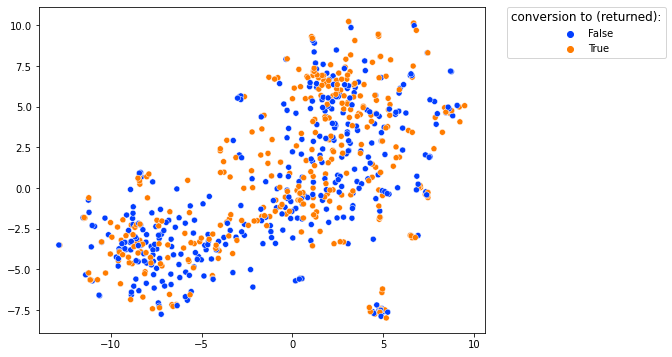

In [339]:
data_ios.rete.project(plot_type ='targets',
                  targets = ['returned'],
                  method='tsne',
                  perplexity = 128);

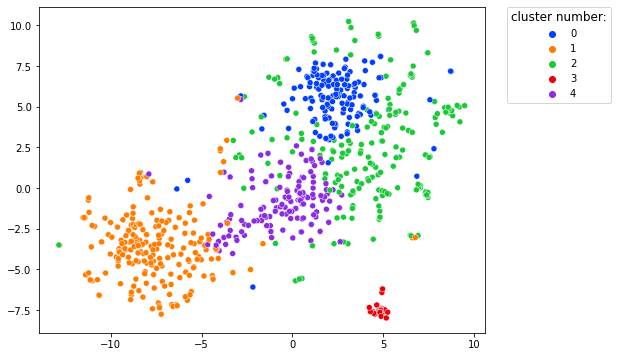

In [340]:
data_ios.rete.project(plot_type ='clusters',
                  method='tsne',
                  perplexity=128);

In [342]:
#Сразу перешли на вкладку жд, смотрели расписание и жд выдачу
data_ios.rete.filter_cluster(0).rete.plot_graph(thresh=0.25,
                       weight_col='session_id',
                       targets = {'lost':'red',
                                  'returned':'green'})

'experiments/graph_2021-01-28 00_34_53_940322.html'

In [343]:
#Совершили поиск через вкладку авиа, переключали вкладки на выдаче
data_ios.rete.filter_cluster(1).rete.plot_graph(thresh=0.25,
                       weight_col='session_id',
                       targets = {'lost':'red',
                                  'returned':'green'})

'experiments/graph_2021-01-28 00_40_54_899918.html'

In [344]:
#Переключали вкладки на выдаче, перейдя сначала на жд
data_ios.rete.filter_cluster(2).rete.plot_graph(thresh=0.25,
                       weight_col='session_id',
                       targets = {'lost':'red',
                                  'returned':'green'})

'experiments/graph_2021-01-28 00_45_58_867603.html'

In [346]:
# Заходили в профиль и редактировали данные
data_ios.rete.filter_cluster(3).rete.plot_graph(thresh=0.35,
                       weight_col='session_id',
                       targets = {'lost':'red',
                                  'returned':'green'})

'experiments/graph_2021-01-28 00_50_55_441483.html'

In [347]:
# Заходили на общую выдачу и переключали вкладки либо нажимали на конкретные предложения
data_ios.rete.filter_cluster(4).rete.plot_graph(thresh=0.35,
                       weight_col='session_id',
                       targets = {'lost':'red',
                                  'returned':'green'})

'experiments/graph_2021-01-28 00_54_31_197670.html'